In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from google.colab import drive
import os

drive.mount('/content/drive')
path_to_dataset = '/content/drive/MyDrive/Encinares, Rico Thesis/Data_Set'
class_names = sorted(os.listdir(path_to_dataset))

IMAGE_SIZE = 300
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 50
dataset = tf.keras.preprocessing.image_dataset_from_directory(path_to_dataset,
                                                              shuffle = True,
                                                              image_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                              batch_size = BATCH_SIZE
)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 2500 files belonging to 5 classes.


In [ ]:
class_names = dataset.class_names
class_names

['BunchyTop', 'Healthy', 'Moko', 'Panama', 'Sigatoka']

In [ ]:
len(dataset)

313

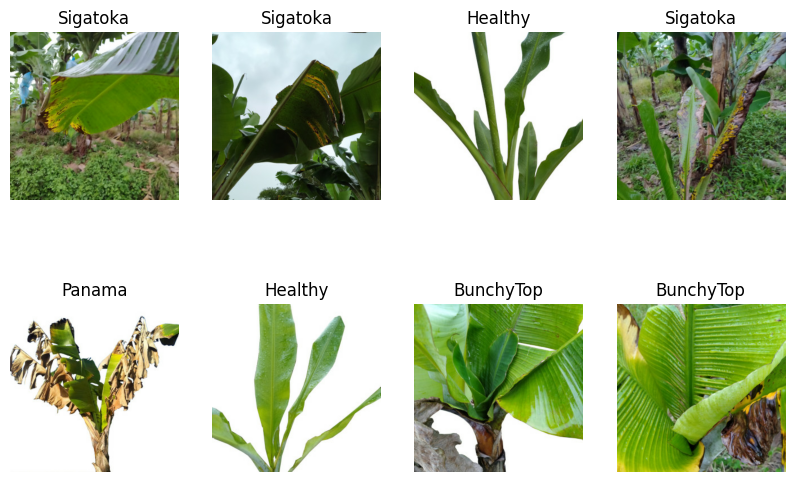

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(8):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [ ]:
len(dataset)

313

In [ ]:
train_size = 0.8
len(dataset)*train_size

250.4

In [ ]:
train_ds = dataset.take(12)
len(train_ds)

12

In [ ]:
test_ds = dataset.skip(12)
len(test_ds)

301

In [ ]:
val_size = 0.1
len(dataset)*val_size

31.3

In [ ]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [ ]:
test_ds = test_ds.skip(1)
len(test_ds)

300

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

250

In [ ]:
len(val_ds)

31

In [ ]:
len(test_ds)

32

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation ='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape = input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (8, 300, 300, 3)          0         
                                                                 
 sequential_1 (Sequential)   (8, 300, 300, 3)          0         
                                                                 
 conv2d (Conv2D)             (8, 298, 298, 32)         896       
                                                                 
 max_pooling2d (MaxPooling2D  (8, 149, 149, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (8, 147, 147, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (8, 73, 73, 64)          0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
EPOCHS = 50
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
250/250 [==============================] - 850s 2s/step - loss: 1.4275 - accuracy: 0.3582 - val_loss: 1.3088 - val_accuracy: 0.4395
Epoch 2/50
250/250 [==============================] - 401s 2s/step - loss: 1.2476 - accuracy: 0.4980 - val_loss: 1.2489 - val_accuracy: 0.4839
Epoch 3/50
250/250 [==============================] - 393s 2s/step - loss: 1.0990 - accuracy: 0.5641 - val_loss: 1.0384 - val_accuracy: 0.6008
Epoch 4/50
250/250 [==============================] - 400s 2s/step - loss: 1.0175 - accuracy: 0.6032 - val_loss: 1.0146 - val_accuracy: 0.5887
Epoch 5/50
250/250 [==============================] - 400s 2s/step - loss: 0.9577 - accuracy: 0.6333 - val_loss: 1.0540 - val_accuracy: 0.5927
Epoch 6/50
250/250 [==============================] - 384s 2s/step - loss: 0.8872 - accuracy: 0.6518 - val_loss: 0.9917 - val_accuracy: 0.6210
Epoch 7/50
250/250 [==============================] - 390s 2s/step - loss: 0.8609 - accuracy: 0.6658 - val_loss: 0.9473 - val_accuracy: 0.6411

In [ ]:
scores = model.evaluate(test_ds)

32/32 [==============================] - 41s 651ms/step - loss: 0.3261 - accuracy: 0.8828


In [ ]:
scores

[0.32608404755592346, 0.8828125]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 250}

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

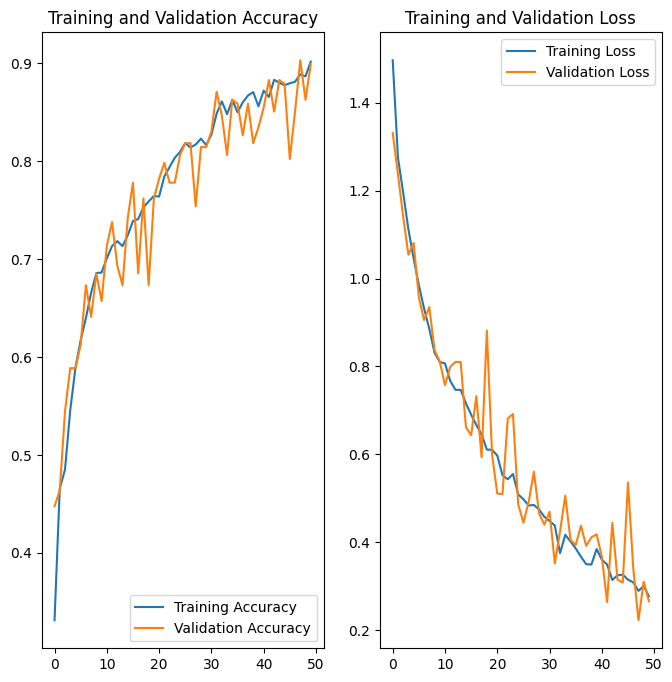

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label:  Sigatoka
1/1 [==============================] - 1s 1s/step
predicted label: Sigatoka


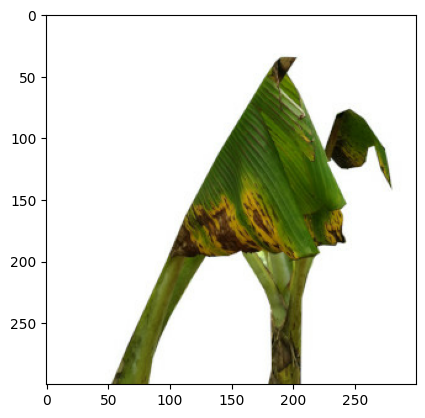

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label: ",class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])),2)
  return predicted_class,confidence

1/1 [==============================] - 0s 61ms/step


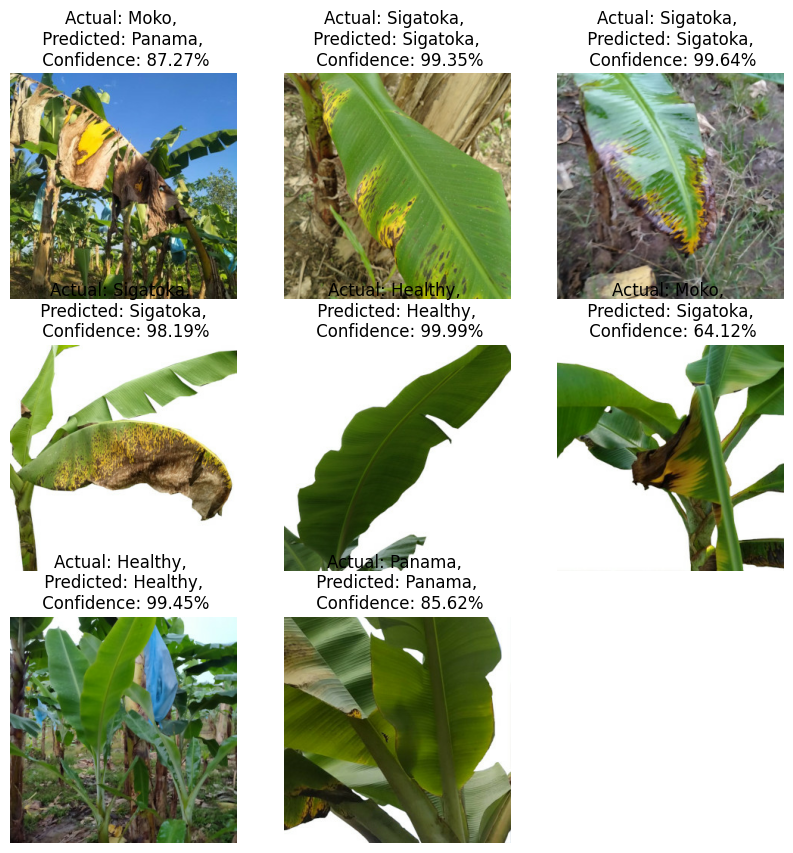

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
    plt.axis("off")

32/32 [==============================] - 15s 478ms/step


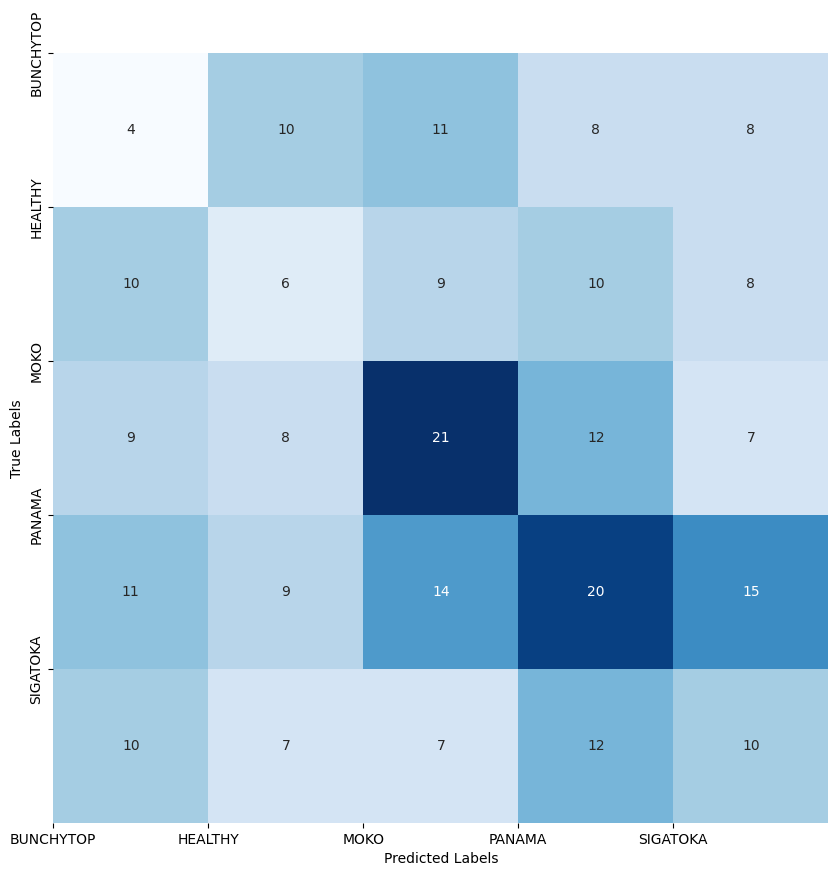

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


class_names = ["BUNCHYTOP", "HEALTHY", "MOKO", "PANAMA","SIGATOKA"]


y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1)


y_true = np.concatenate([y for x, y in val_ds], axis=0)


cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')


tick_labels = class_names
plt.xticks(np.arange(len(class_names)), tick_labels)
plt.yticks(np.arange(len(class_names)), tick_labels)

plt.show()

31/31 [==============================] - 13s 418ms/step


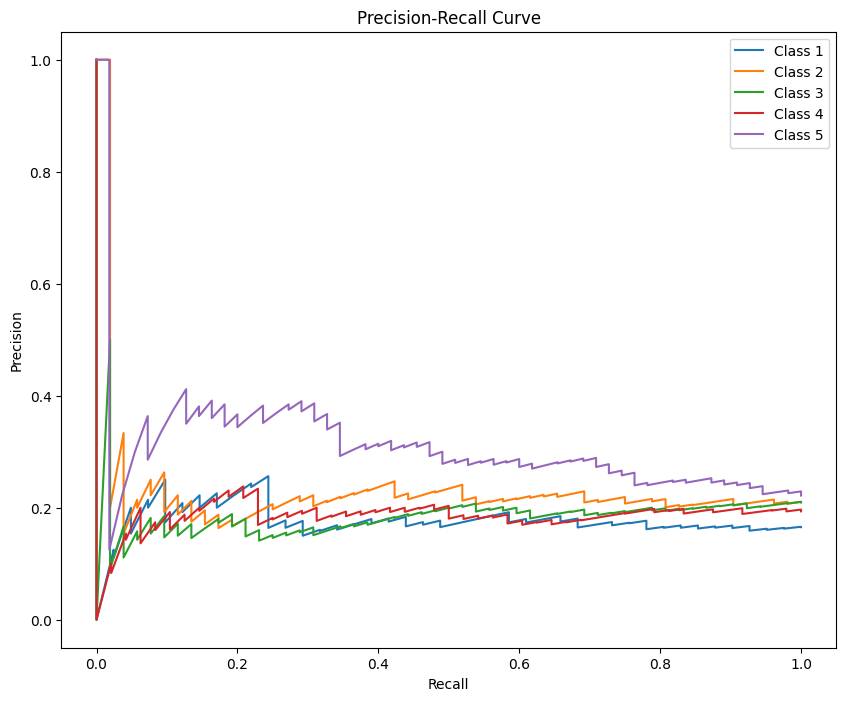

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Assuming you have the trained model and the validation dataset (val_ds)

# Make predictions on the validation dataset
y_pred_prob = model.predict(val_ds)

# Convert true and predicted labels to binary format
y_true_binary = label_binarize(y_true, classes=np.unique(y_true))
y_pred_binary = y_pred_prob

# Calculate precision and recall values for each class
precision = dict()
recall = dict()
for i in range(len(np.unique(y_true))):
    precision[i], recall[i], _ = precision_recall_curve(y_true_binary[:, i], y_pred_binary[:, i])

# Plot the precision-recall curves for each class
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(y_true))):
    plt.plot(recall[i], precision[i], label='Class {}'.format(i+1))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

32/32 [==============================] - 18s 546ms/step


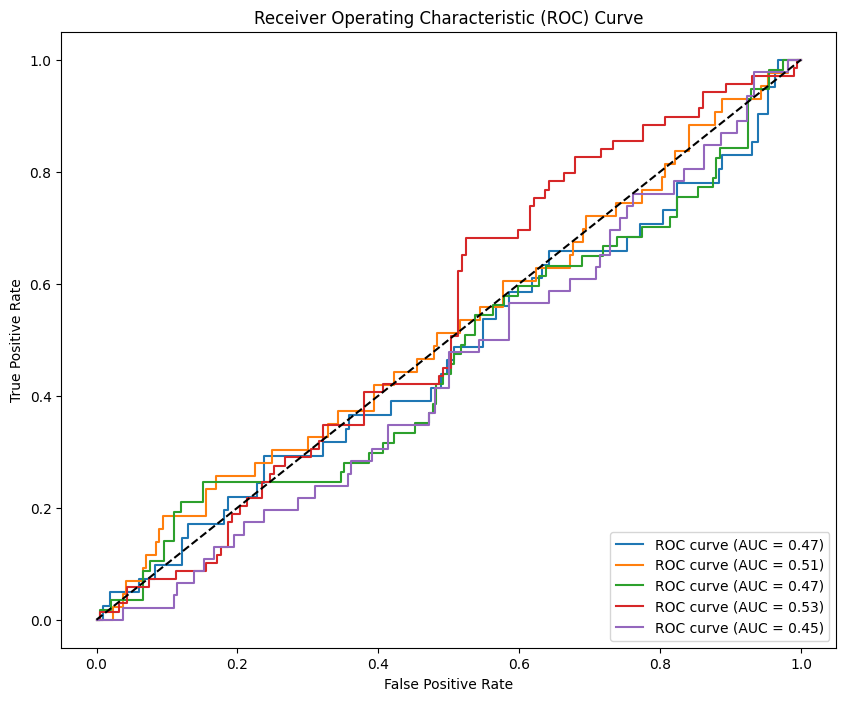

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming you have the trained model and the validation dataset (val_ds)

# Make predictions on the validation dataset
y_pred_prob = model.predict(val_ds)

# Convert true and predicted labels to binary format
y_true_binary = label_binarize(y_true, classes=np.unique(y_true))
y_pred_binary = y_pred_prob

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_true))):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(y_true))):
    plt.plot(fpr[i], tpr[i], label='ROC curve (AUC = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model_version = 1
model.save('/content/drive/MyDrive/models/model_{}'.format(model_version))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
from PIL import Image
import numpy as np
import tensorflow as tf


drive.mount('/content/drive')


model_path = "/content/drive/MyDrive/models/model_1"
test_image_path = "/content/drive/MyDrive/Data_Set/Sigatoka/With Background/IMG20230301082449.jpg"



model = tf.keras.models.load_model(model_path)


image = Image.open(test_image_path)

input_data = np.expand_dims(image, axis=0)
print(input_data.shape)


predictions = model.predict(input_data)
predicted_class = np.argmax(predictions)


print(f"Predicted class: {predicted_class}")
#Class
#Bunchy Top = 0
#Healthy = 1
#Moko = 2
#Panama = 3
#Sigatoka = 4

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(1, 300, 300, 3)
1/1 [==============================] - 0s 151ms/step
Predicted class: 4
